# Lesson 6: Essay Writer

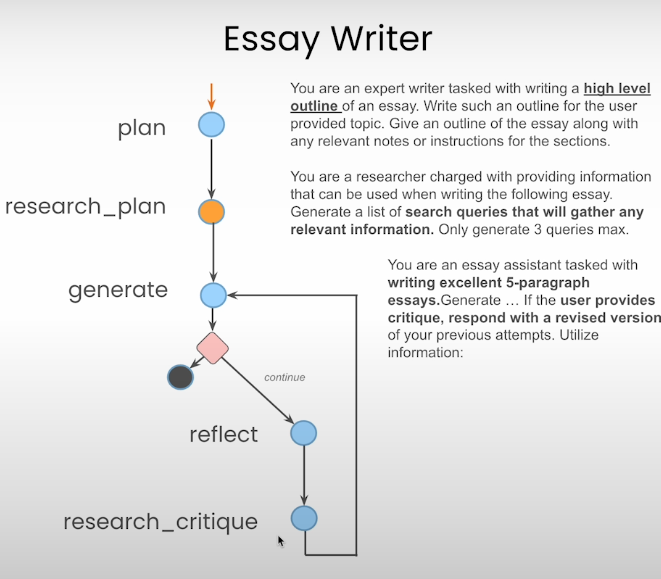

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [10]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [12]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
builder.set_entry_point("planner")

In [21]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
graph = builder.compile(checkpointer=memory)

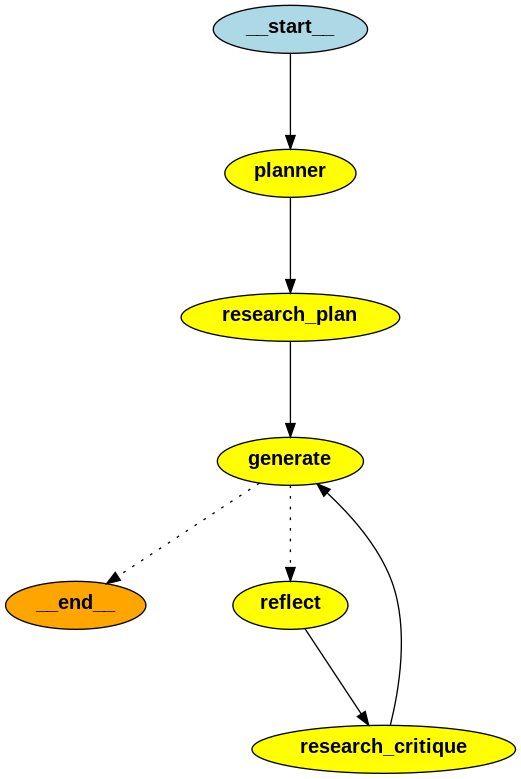

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

It generates a plan → then does research → gets back documents → writes a draft.

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and purpose\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIII. Langsmith\n    A. Definition and purpose\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability and performance\n    C. Security and privacy\n    D. Adoption and popularity\n    E. Future prospects\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for the future of blockchain technology\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure a clear and concise explanation of Langchain and Langsmith in the introduction.\n- Provide specific examp

{'research_critique': {'content': ["What's the difference between Langchain and LangSmith? Langchain is a prototyping tool designed to help you quickly build applications with language models. On the other hand, LangSmith is geared towards production, offering features for version control, experimenting, and deploying language model applications at scale.", 'LangChain vs LangGraph vs LangFlow vs LangSmith: A Detailed Comparison In the rapidly evolving world of AI, building applications powered by advanced language models like GPT-4 or Llama 3 has become more accessible, thanks to frameworks like LangChain, LangGraph, LangFlow, and LangSmith. While these tools share some similarities, they cater to different aspects of AI application development. LangChain is an open-source framework designed to streamline the development of applications leveraging language models. LangFlow simplifies the prototyping process by providing a visual, drag-and-drop interface to design and test workflows. La

{'generate': {'draft': '**Title: Exploring the Contrasts Between LangChain and LangSmith**\n\nI. Introduction\nIn the realm of AI application development, tools like LangChain and LangSmith play pivotal roles. LangChain is a prototyping tool aimed at swiftly constructing applications using language models, while LangSmith is tailored for production, offering features for version control, experimentation, and deploying language model applications at scale. This essay delves into the distinctions between LangChain and LangSmith to provide a comprehensive understanding of their unique functionalities.\n\nII. LangChain\nA. LangChain Defined: An overview of LangChain as a prototyping tool for building applications with language models.\nB. Key Features: Highlighting the characteristics that make LangChain stand out in the development process.\nC. Use Cases: Illustrating practical applications where LangChain excels in streamlining AI development.\nD. Pros and Cons: Evaluating the advantages

## Essay Writer Interface

In [26]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [27]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

IMPORTANT: You are using gradio version 4.31.3, however version 4.44.1 is available, please upgrade.
--------
Running on local URL:  http://0.0.0.0:8080
Running on public URL: https://aff7c4592d981ce489.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
